In [1]:
from scipy import stats 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Epydemix import
from epydemix.population import Population
from epydemix.epimodel import EpiModel, stochastic_simulation
from epydemix.plotting import plot_quantiles
from epydemix.calibration import calibration_top_perc

# Population Object

In [2]:
population = Population(name="Indonesia")

# add contact matrices
population.add_contact_matrix(np.load("./basins/Indonesia/contacts-matrix/contacts_matrix_work.npz")["arr_0"], 
                              layer_name="work")
population.add_contact_matrix(np.load("./basins/Indonesia/contacts-matrix/contacts_matrix_home.npz")["arr_0"], 
                              layer_name="home")
population.add_contact_matrix(np.load("./basins/Indonesia/contacts-matrix/contacts_matrix_community.npz")["arr_0"], 
                              layer_name="community")
population.add_contact_matrix(np.load("./basins/Indonesia/contacts-matrix/contacts_matrix_school.npz")["arr_0"], 
                              layer_name="school")

# add population in different age groups
population.add_population(Nk=pd.read_csv("./basins/Indonesia/demographic/Nk.csv")["value"].values, 
                          Nk_names=pd.read_csv("./basins/Indonesia/demographic/Nk.csv")["group"].values)

# EpiModel Object

In [3]:
# create model 
model = EpiModel(compartments=["S", "R"])

# add compartments
model.add_compartments("I")

# add parameters
model.add_parameters({"beta": 0.04, "mu": 0.1})

# add transitions 
model.add_transition(source="S", target="I", rate_name="beta", agent="I")
model.add_transition(source="I", target="R", rate_name="mu")

# add interventions
model.add_intervention(layer_name="work", start_date="2020-01-01", end_date="2020-05-01", reduction_factor=0.3)
#model.add_intervention(layer_name="school", start_date="2020-01-01", end_date="2020-02-01", new_matrix=population.contact_matrices["community"])


In [4]:
compartments, df_quantiles = model.simulate(population=population, 
                              start_date="2019-12-01", 
                              end_date="2020-06-01", 
                              S=population.Nk - np.ones(len(population.Nk)),
                              I=np.ones(len(population.Nk)),
                              R=np.zeros(len(population.Nk)),
                              steps=100)

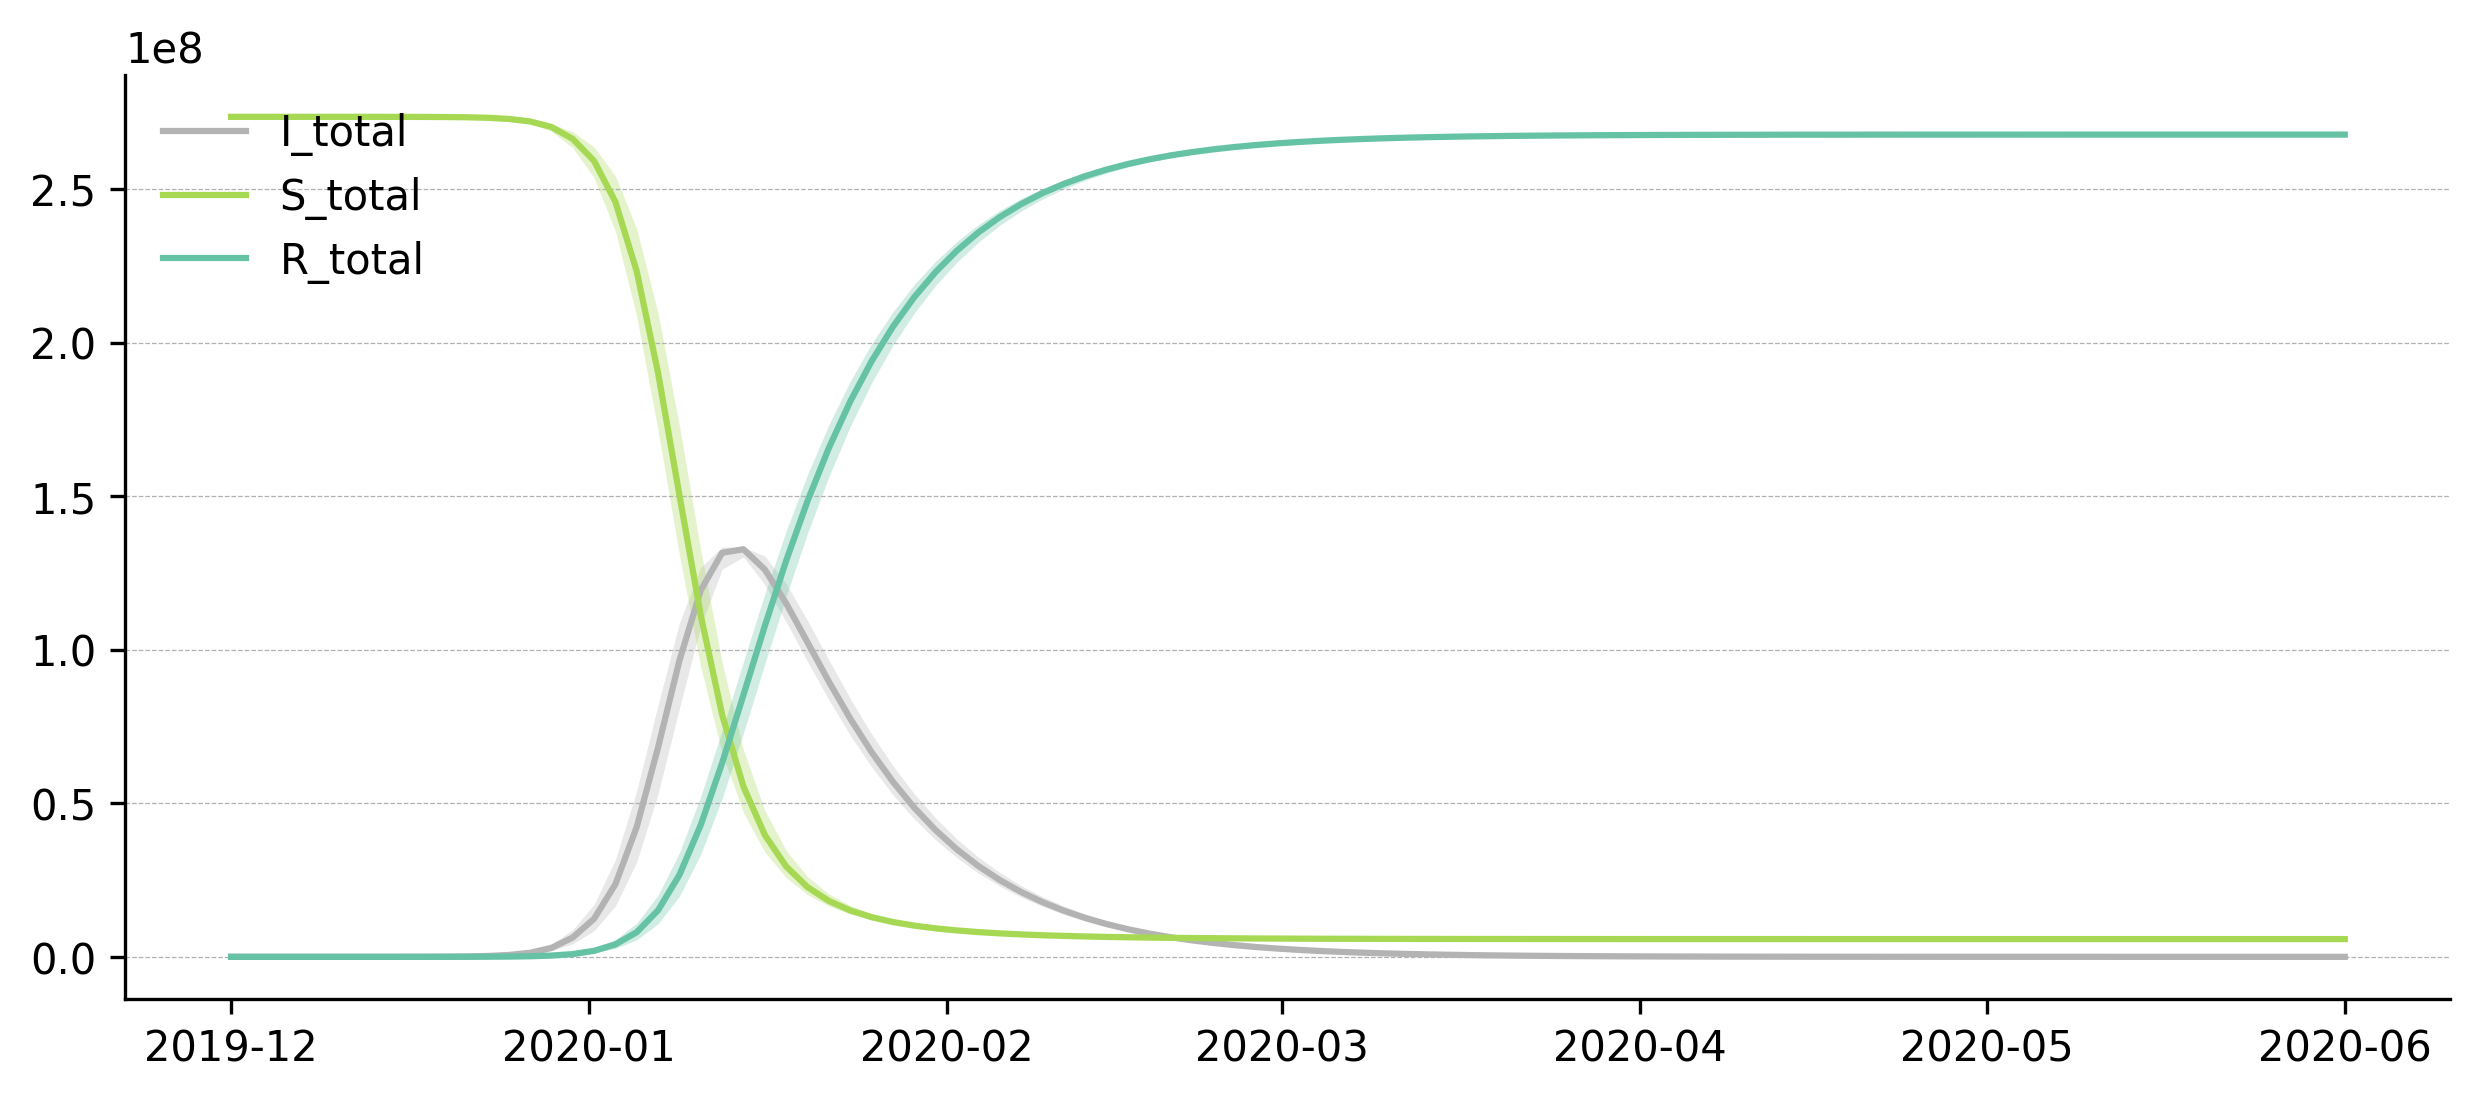

In [5]:
plot_quantiles(df_quantiles, columns=["I_total", "S_total", "R_total"])


# Calibration

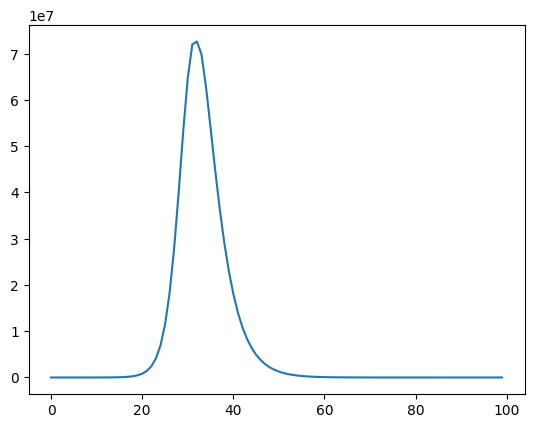

In [7]:
# first we generate "Fake" data for the calibration 
model = EpiModel(compartments=["S", "I", "R"])
model.add_parameters({"beta": 0.03, "mu": 0.2})
model.add_transition(source="S", target="I", rate_name="beta", agent="I")
model.add_transition(source="I", target="R", rate_name="mu")
compartments, df_quantiles = model.simulate(population=population, 
                              start_date="2019-12-01", 
                              end_date="2020-06-01", 
                              S=population.Nk - np.ones(len(population.Nk)),
                              I=np.ones(len(population.Nk)),
                              R=np.zeros(len(population.Nk)),
                              steps=100)

data = df_quantiles.loc[(df_quantiles["quantile"] == 0.5)]["I_total"].values

plt.plot(data)

In [10]:
# create model 
model = EpiModel(compartments=["S", "I", "R"])
model.add_parameters({"beta": 0.03, "mu": 0.2})
model.add_transition(source="S", target="I", rate_name="beta", agent="I")
model.add_transition(source="I", target="R", rate_name="mu")

# initial conditions
S=population.Nk - np.ones(len(population.Nk))
I=np.ones(len(population.Nk))
R=np.zeros(len(population.Nk))

# simulation dates
steps = 100
start_date="2019-12-01"
end_date="2020-06-01"
start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
simulation_dates = pd.date_range(start=start_date, end=end_date, periods=steps).tolist()
model.compute_contact_reductions(population, simulation_dates)

# parameters
parameters = {"Cs": model.Cs, 
              "Nk": population.Nk, 
              "S": S, 
              "I": I, 
              "R": R, 
              "epimodel": model, 
              "dt": np.diff(simulation_dates)[0] / timedelta(days=1),
              "population": population, 
              "simulation_dates": simulation_dates}
parameters.update(model.parameters)

In [33]:
def post_processing_function(results, **parameters): 
    inf_idx = parameters["epimodel"].compartments_idx["I"]
    return {"data": results["I_total"]}


results = calibration_top_perc(
                                simulation_function=stochastic_simulation, 
                                parameters=parameters,
                                priors={"beta": stats.uniform(0.025, 0.035), 
                                        "mu": stats.uniform(0.15, 0.25)}, 
                                data={"data": data},
                                top_perc=0.05,
                                Nsim=2000,
                                post_processing_function=post_processing_function)

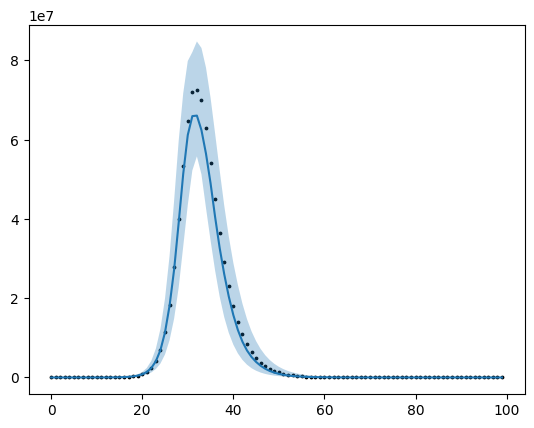

In [34]:
df_quantiles = results.get_selected_quantiles()

med = df_quantiles.loc[df_quantiles["quantile"] == 0.5]
plt.plot(med.data.values)
plt.scatter(range(len(data)), data, color="k", s=3)

q1, q2 = df_quantiles.loc[df_quantiles["quantile"] == 0.05], df_quantiles.loc[df_quantiles["quantile"] == 0.95]
plt.fill_between(range(len(data)), q1.data.values, q2.data.values, alpha=0.3)


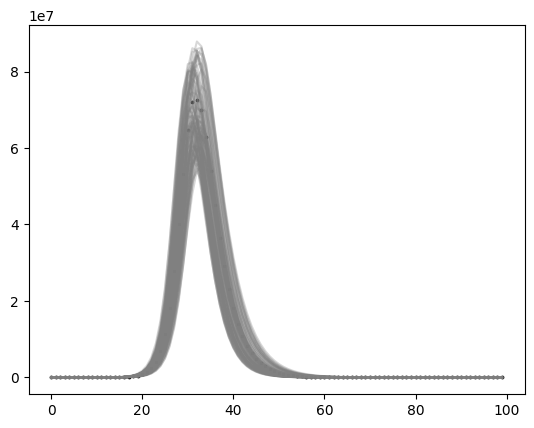

In [35]:
trajectories = results.get_selected_trajectories()
for t in trajectories: 
    plt.plot(t, color="grey", alpha=0.3)

plt.scatter(range(len(data)), data, color="k", s=3)

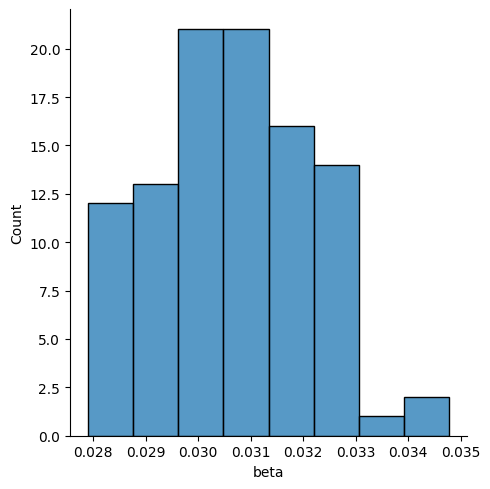

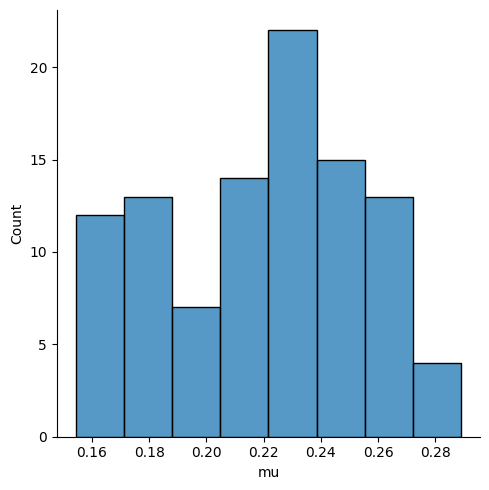

In [36]:
import seaborn as sns 
df_posterior = results.get_posterior_distribution()

sns.displot(data=df_posterior, x="beta")
sns.displot(data=df_posterior, x="mu")


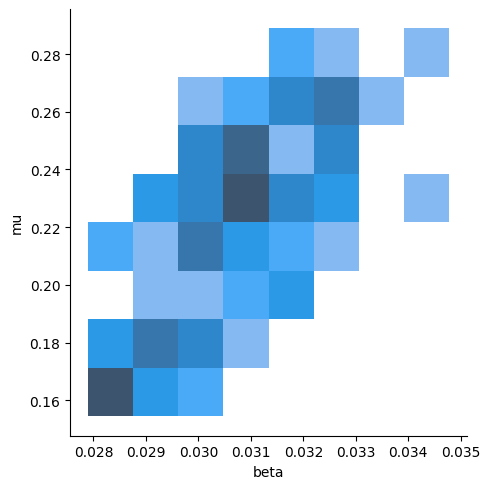

In [37]:
sns.displot(data=df_posterior, x="beta", y="mu")